# DA1 - Spam Classification model using pretrained BERT
Goutham Krishnan 21BAI1007

Slot: L23 + L24

In [1]:
# Importing libraries
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, get_linear_schedule_with_warmup, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data - spam.csv

In [2]:
df = pd.read_csv("spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def load_data(path):
    df = pd.read_csv(path)
    texts = df["Message"].tolist()
    labels = [1 if category=="spam" else 0 for category in df["Category"]]
    return texts, labels

data_path = "spam.csv"
texts, labels = load_data(data_path)
# Printing the list of texts and labels
for i in range(10):
    print(f"Text: {texts[i]} \t| Label: {labels[i]}")

Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 	| Label: 0
Text: Ok lar... Joking wif u oni... 	| Label: 0
Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 	| Label: 1
Text: U dun say so early hor... U c already then say... 	| Label: 0
Text: Nah I don't think he goes to usf, he lives around here though 	| Label: 0
Text: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv 	| Label: 1
Text: Even my brother is not like to speak with me. They treat me like aids patent. 	| Label: 0
Text: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune 	| Label: 0
Text: WINNER!! As a valued network customer you have been s

In [4]:
## Preparing the dataset -> for input to the pytorch dataloader
class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, index):
        texts = self.texts[index]
        labels = self.labels[index]
        encoding = self.tokenizer(texts, add_special_tokens=True, return_tensors='pt', max_length = self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(labels)}

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
print("Length of training set: ", len(train_texts))
print("Length of test set: ", len(val_texts))

Length of training set:  4457
Length of test set:  1115


### BERT Model for sequence classification

In [5]:
## Pretrained bert-base-uncased model from huggingface
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
## BERT model parameters
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 128
batch_size = 16
num_epochs = 10
learning_rate = 1e-3

In [7]:
## Dataloader
train_dataset = SpamDataset(train_texts, train_labels, bert_tokenizer, max_length)
test_dataset = SpamDataset(val_texts, val_labels, bert_tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Training and Validation

In [9]:
## Training the model
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions)

# Training and validation loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy = evaluate(model, test_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")

# Save the model as a .pth file
torch.save(model.state_dict(), "BERT_spam_classifier.pth")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


Validation Accuracy: 0.9955
Epoch 2/10
Validation Accuracy: 0.9928
Epoch 3/10
Validation Accuracy: 0.9928
Epoch 4/10
Validation Accuracy: 0.9928
Epoch 5/10
Validation Accuracy: 0.9928
Epoch 6/10
Validation Accuracy: 0.9928
Epoch 7/10
Validation Accuracy: 0.9928
Epoch 8/10
Validation Accuracy: 0.9928
Epoch 9/10
Validation Accuracy: 0.9928
Epoch 10/10
Validation Accuracy: 0.9928


### Sample Prediction

In [15]:
# Sample Predictions
def predict_spam(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
    return "spam" if preds.item() == 1 else "not spam"

for i in range(30):
    # Generate a random number between 0 and len(val_texts) -> get a random test text
    k = np.random.randint(0, len(val_texts))
    test_text = val_texts[k]
    sentiment = predict_spam(test_text, model, bert_tokenizer, device)
    print("Sample Text: ", val_texts[k])
    truth = "spam" if val_labels[k]==1 else "not spam"
    print(f"Correct Sentiment: {truth} | Predicted sentiment: {sentiment}")
    print("\n")

Sample Text:  URGENT! We are trying to contact you. Last weekends draw shows that you have won a £900 prize GUARANTEED. Call 09061701939. Claim code S89. Valid 12hrs only
Correct Sentiment: spam | Predicted sentiment: spam


Sample Text:  Sorry, I'll call later
Correct Sentiment: not spam | Predicted sentiment: not spam


Sample Text:  Congratulations! Thanks to a good friend U have WON the £2,000 Xmas prize. 2 claim is easy, just call 08718726971 NOW! Only 10p per minute. BT-national-rate.
Correct Sentiment: spam | Predicted sentiment: spam


Sample Text:  Love you aathi..love u lot..
Correct Sentiment: not spam | Predicted sentiment: not spam


Sample Text:  8007 FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W4 5WQ norm 150p/tone 16+
Correct Sentiment: spam | Predicted sentiment: spam


Sample Text:  Oh k. . I will come tomorrow
Correct Sentiment: not spam | Predicted sentiment: not spam


Sample

### Model Metrics

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, f1_score, classification_report
import seaborn as sns

model.load_state_dict(torch.load("BERT_spam_classifier.pth", map_location=device)) # Loading the model from the .pth file

def evaluate_metrics(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    # Confusion Matrix
    cm = confusion_matrix(actual_labels, predictions)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC Score
    fpr, tpr, _ = roc_curve(actual_labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return actual_labels, predictions

Confusion Matrix:
[[960   6]
 [  2 147]]


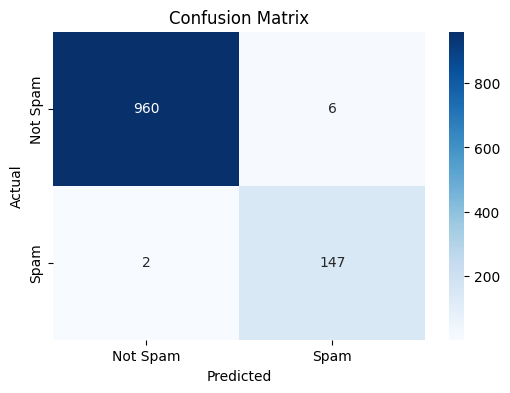

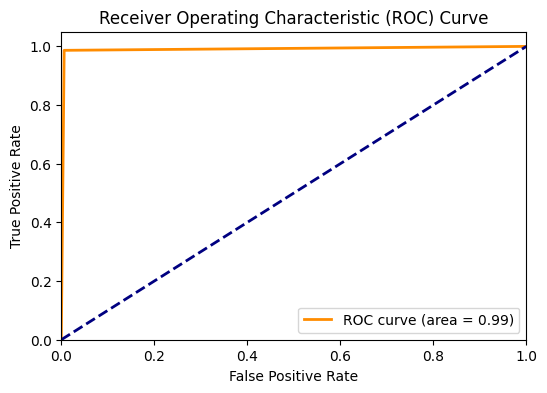

Precision: 0.9608
F1 Score: 0.9735
Classification Report:
              precision    recall  f1-score   support

    Not Spam       1.00      0.99      1.00       966
        Spam       0.96      0.99      0.97       149

    accuracy                           0.99      1115
   macro avg       0.98      0.99      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [9]:
def print_classification_metrics(actual_labels, predictions):
    precision = precision_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Classification report
    print("Classification Report:")
    print(classification_report(actual_labels, predictions, target_names=["Not Spam", "Spam"]))

# After training, to evaluate the model, call these functions:
actual_labels, predictions = evaluate_metrics(model, test_dataloader, device)
print_classification_metrics(actual_labels, predictions)